<a href="https://colab.research.google.com/github/thephann/Mercari-Price-Suggestion-/blob/main/MercariFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Các thư viện cần thiết**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#Đọc file từ drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Tải dữ liệu traning**

In [3]:
#Dùng pandas để đọc dữ liệu
train_data = pd.read_csv('/content/drive/My Drive/Datasets/Mercari/train.tsv',sep='\t')
train_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
#Kiểm tra các giá trị null
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [5]:
#Chia tập train thành tập train và validation với tỉ lệ tập validation là 0.1
train_data = train_data[train_data['price'] > 0].reset_index(drop=True)
train_data,validation_data=train_test_split(train_data,test_size=0.1,random_state=42)
print(train_data.shape)
print(validation_data.shape)

(1333494, 8)
(148167, 8)


In [6]:
train = train_data.copy()
valid = validation_data.copy()

In [7]:
#Hàm chia category thành các sub category
def split_categories(category):
    try:
      sub_category1,sub_category2,sub_category3 = category.split("/")
      return sub_category1,sub_category2,sub_category3
    except:
      return ("No label","No label","No label")

def create_split_categories(data):
    data['sub_category1'],data['sub_category2'],data['sub_category3']=zip(*data['category_name'].\
                                                                  apply(lambda x: split_categories(x)))

#Hàm thay thế các giá trị null   
def fill_missing_values(data):
    data['category_name'].fillna('unknown_cat', inplace=True)
    data['brand_name'].fillna('unknown_brand', inplace=True)
    data['item_description'].fillna('unknown_description', inplace=True)
    return data

In [8]:
create_split_categories(train_data)
create_split_categories(validation_data)

fill_missing_values(train_data)
fill_missing_values(validation_data)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,sub_category1,sub_category2,sub_category3
639825,640169,Mickey Mouse Crop Top,4,Women/Tops & Blouses/T-Shirts,Disney,6.0,1,white crop top. mickey mouse design on the fro...,Women,Tops & Blouses,T-Shirts
506709,506976,Converse Shoreline Wm's Sneaker Sz 9,1,Women/Shoes/Fashion Sneakers,Converse,38.0,0,Chuck Taylor's Shoreline Women's Sneaker Size ...,Women,Shoes,Fashion Sneakers
1391997,1392815,Shellshell bundle,3,Kids/Girls (4+)/Other,unknown_brand,19.0,1,3 leotards as pictured,Kids,Girls (4+),Other
805573,806019,Wallflower plugins,3,Home/Home Décor/Home Fragrance,Bath & Body Works,13.0,1,Five of them,Home,Home Décor,Home Fragrance
669893,670253,New Nike Pros HOT PINK size M,2,Women/Athletic Apparel/Shorts,Nike,14.0,1,Bought for my daughter and they are too small ...,Women,Athletic Apparel,Shorts
...,...,...,...,...,...,...,...,...,...,...,...
835326,835783,Akai MPK mini MkII Usb Midi Keyboard,2,Other/Musical instruments/Keyboards,Akai,51.0,0,"Barely used, in excellent condition",Other,Musical instruments,Keyboards
1317637,1318394,FREE SHIP WHITE BROWNING DECAL BUNDLE,1,Women/Women's Accessories/Other,Browning,3.0,1,Bundle for anyone! Ships TOMORROW! (Saturday) ...,Women,Women's Accessories,Other
510142,510413,Black sequin dress,1,"Women/Dresses/Above Knee, Mini",unknown_brand,22.0,0,Brand-new sealed package Mardi gras Party Sequ...,Women,Dresses,"Above Knee, Mini"
1213839,1214539,TC Lularoe leggings fairy skeletons,2,Women/Jeans/Leggings,unknown_brand,35.0,1,"TC, only tried on",Women,Jeans,Leggings


**Tải dữ liệu testing**

In [9]:
test_data = pd.read_csv('/content/drive/My Drive/Datasets/Mercari/test_stg2.tsv',sep='\t')
test = test_data.copy()

In [10]:
test_data.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [11]:
create_split_categories(test_data)
fill_missing_values(test_data)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,sub_category1,sub_category2,sub_category3
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,unknown_brand,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,unknown_brand,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,unknown_brand,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,unknown_brand,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality
...,...,...,...,...,...,...,...,...,...,...
3460720,3460720,DARK SAMPLE BYE FOUNDATION MOISTURIZER,1,Beauty/Fragrance/Women,unknown_brand,1,It cosmetics Bye Bye Foundation Full Coverage ...,Beauty,Fragrance,Women
3460721,3460721,bundle for @brandystash,2,Women/Pants/Other,unknown_brand,1,♡2 pairs of omighty trackiez. one m and one s....,Women,Pants,Other
3460722,3460722,Toddler High-top Converse,3,Kids/Girls 0-24 Mos/Shoes,Nike,0,Size 5 (toddler). Pink high top converse shoes...,Kids,Girls 0-24 Mos,Shoes
3460723,3460723,Yoga Sling Sandals,1,Women/Shoes/Sandals,Sanuk,1,super super comfy. i have a pair but ordered t...,Women,Shoes,Sandals


#**Phân tích dữ liệu**

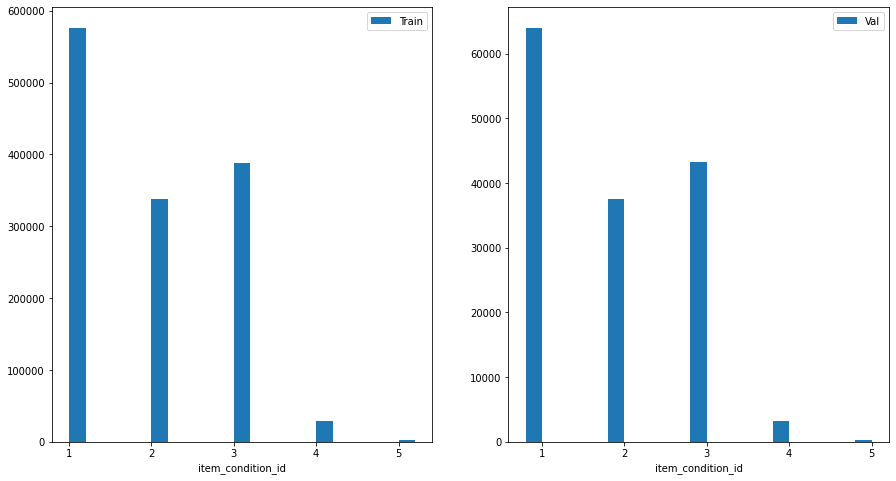

In [12]:
#So sánh tỉ lệ item_condition_id giữa train và validation 
from collections import Counter

train_cond_id = Counter(list(train_data['item_condition_id']))
val_cond_id = Counter(list(validation_data['item_condition_id']))

fig, (ax1,ax3) = plt.subplots(1,2, figsize=(15,8))

ax1.bar(train_cond_id.keys(), train_cond_id.values(), width=0.2, align='edge', label='Train')
ax1.set_xticks([1,2,3,4,5])
ax1.set_xlabel('item_condition_id')
ax1.legend()


ax3.bar(val_cond_id.keys(), val_cond_id.values(), width=-0.2, align='edge', label='Val')
ax3.set_xticks([1,2,3,4,5])
ax3.set_xlabel('item_condition_id')
ax3.legend()

fig.show()

**Phân tích feature price**

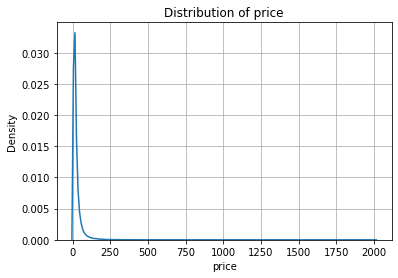

In [13]:
sns.kdeplot(data=train_data['price'])
plt.title('Distribution of price')
plt.grid(True)

In [14]:
#Đưa price về dạng phân phối chuẩn
train_data['log_prices']= np.log(train_data['price']+1)
validation_data['log_prices']= np.log(validation_data['price']+1)

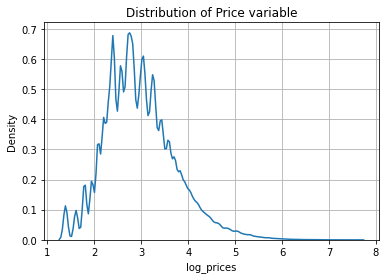

In [15]:
train_data['log_prices']= np.log(train_data['price']+1)
sns.kdeplot(data=train_data['log_prices'])
plt.title("Distribution of Price variable")
plt.grid(True)

**Phân tích feature category name**

In [16]:
train_category_name = Counter(list(train_data['category_name']))
val_category_name = Counter(list(validation_data['category_name']))
test_category_name = Counter(list(test_data['category_name']))

In [17]:
print("Top 10 categories in train data: ")
train_category_name.most_common(10)

Top 10 categories in train data: 


[('Women/Athletic Apparel/Pants, Tights, Leggings', 54097),
 ('Women/Tops & Blouses/T-Shirts', 41708),
 ('Beauty/Makeup/Face', 30940),
 ('Beauty/Makeup/Lips', 26942),
 ('Electronics/Video Games & Consoles/Games', 23897),
 ('Beauty/Makeup/Eyes', 22610),
 ('Electronics/Cell Phones & Accessories/Cases, Covers & Skins', 22207),
 ('Women/Underwear/Bras', 19108),
 ('Women/Tops & Blouses/Tank, Cami', 18231),
 ('Women/Dresses/Above Knee, Mini', 18200)]

In [18]:
print("Top 10 categories in validation data: ")
val_category_name.most_common(10)

Top 10 categories in validation data: 


[('Women/Athletic Apparel/Pants, Tights, Leggings', 6055),
 ('Women/Tops & Blouses/T-Shirts', 4641),
 ('Beauty/Makeup/Face', 3380),
 ('Beauty/Makeup/Lips', 2959),
 ('Electronics/Video Games & Consoles/Games', 2650),
 ('Beauty/Makeup/Eyes', 2590),
 ('Electronics/Cell Phones & Accessories/Cases, Covers & Skins', 2461),
 ('Women/Underwear/Bras', 2146),
 ('Women/Tops & Blouses/Blouse', 2121),
 ('Women/Tops & Blouses/Tank, Cami', 2039)]

In [19]:
print("Top 10 categories in test data: ")
test_category_name.most_common(10)

Top 10 categories in test data: 


[('Women/Athletic Apparel/Pants, Tights, Leggings', 139412),
 ('Women/Tops & Blouses/T-Shirts', 108334),
 ('Beauty/Makeup/Face', 80054),
 ('Beauty/Makeup/Lips', 69655),
 ('Electronics/Video Games & Consoles/Games', 62577),
 ('Beauty/Makeup/Eyes', 59469),
 ('Electronics/Cell Phones & Accessories/Cases, Covers & Skins', 57443),
 ('Women/Underwear/Bras', 50008),
 ('Women/Tops & Blouses/Tank, Cami', 47785),
 ('Women/Tops & Blouses/Blouse', 47534)]

**Phân tích feature brand name**

In [20]:
train_brand_name = Counter(list(train_data['brand_name']))
val_brand_name = Counter(list(validation_data['brand_name']))
test_brand_name = Counter(list(test_data['brand_name']))

In [21]:
print("Top 10 brands in train data: ")
train_brand_name.most_common(10)

Top 10 brands in train data: 


[('unknown_brand', 569214),
 ('Nike', 48591),
 ('PINK', 48550),
 ("Victoria's Secret", 43196),
 ('LuLaRoe', 27861),
 ('Apple', 15556),
 ('FOREVER 21', 13655),
 ('Nintendo', 13454),
 ('Lululemon', 13109),
 ('Michael Kors', 12471)]

In [22]:
print("Top 10 brands in validation data: ")
val_brand_name.most_common(10)

Top 10 brands in validation data: 


[('unknown_brand', 63122),
 ('PINK', 5522),
 ('Nike', 5415),
 ("Victoria's Secret", 4815),
 ('LuLaRoe', 3134),
 ('Apple', 1758),
 ('Nintendo', 1544),
 ('FOREVER 21', 1523),
 ('Michael Kors', 1445),
 ('Lululemon', 1441)]

In [23]:
print("Top 10 brands in test data: ")
test_brand_name.most_common(10)

Top 10 brands in test data: 


[('unknown_brand', 1476490),
 ('Nike', 125749),
 ('PINK', 125712),
 ("Victoria's Secret", 112376),
 ('LuLaRoe', 72034),
 ('Apple', 40365),
 ('FOREVER 21', 35676),
 ('Nintendo', 35446),
 ('Lululemon', 34147),
 ('Michael Kors', 32078)]

#**Xử lý dữ liệu**

**Làm sạch dữ liệu**

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
#Hàm loại bỏ stop words
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

In [26]:
train_data['item_description'] = train_data['item_description'].apply(remove_stop_words)
validation_data['item_description'] = validation_data['item_description'].apply(remove_stop_words)
test_data['item_description'] = test_data['item_description'].apply(remove_stop_words)

In [27]:
#Hàm xử lý dữ liệu dạng text(đưa các từ viết tắt thành dạng thường ,loại bỏ ký tự đặc biệt, chuyển các từ in hóa thành in thường)

from tqdm import tqdm
import re

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_preprocessing(text_col):
  preprocessed_total = []
  for sentence in tqdm(text_col.values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    preprocessed_total.append(sent.lower().strip())
  return preprocessed_total

In [28]:
train_data['item_description']=text_preprocessing(train_data['item_description'])
validation_data['item_description']=text_preprocessing(validation_data['item_description'])
test_data['item_description']=text_preprocessing(test_data['item_description'])

train_data['name']=text_preprocessing(train_data['name'])
validation_data['name']=text_preprocessing(validation_data['name'])
test_data['name']=text_preprocessing(test_data['name'])

100%|██████████| 3460725/3460725 [00:48<00:00, 71127.30it/s]


In [29]:
print(train_data['item_description'].iloc[33],len(train_data['item_description'].iloc[33].split(' ')))
print(train['item_description'].iloc[33],len(train['item_description'].iloc[33].split(' ')))

100 brand new tags cotton brown infinity scarf forever 21 beige beanie hat 13
100% Brand New with Tags Cotton On Brown Infinity Scarf Forever 21 Beige Beanie Hat 15


In [30]:
#Hàm xử lý dữ liệu dạng category
def clean_category(cate_col):
    
    

    cate_list = []
    for i in tqdm(cate_col.values):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cate_list.append(i.strip())
    
    return cate_list

In [31]:
train_data['sub_category1'] = clean_category(train_data['sub_category1'])
validation_data['sub_category1'] = clean_category(validation_data['sub_category1'])
test_data['sub_category1'] = clean_category(test_data['sub_category1'])

train_data['sub_category2'] = clean_category(train_data['sub_category2'])
validation_data['sub_category2'] = clean_category(validation_data['sub_category2'])
test_data['sub_category2'] = clean_category(test_data['sub_category2'])

train_data['sub_category3'] = clean_category(train_data['sub_category3'])
validation_data['sub_category3'] = clean_category(validation_data['sub_category3'])
test_data['sub_category3'] = clean_category(test_data['sub_category3'])

100%|██████████| 3460725/3460725 [00:07<00:00, 437539.66it/s]


In [32]:
#Xử lý dữ liệu brand name 
train_data['brand_name'] = clean_category(train_data['brand_name'])
validation_data['brand_name'] = clean_category(validation_data['brand_name'])
test_data['brand_name'] = clean_category(test_data['brand_name'])

100%|██████████| 3460725/3460725 [00:07<00:00, 435751.28it/s]


**Vector hóa dữ liệu**

In [33]:
#Sử dụng bag of words dựa vào CountVectorizer của thư viện sklearn để xử lý dữ liệu dạng category
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer=CountVectorizer().fit(train_data['sub_category1'])                 
bow_cat1_train=countvectorizer.transform(train_data['sub_category1'])
bow_cat1_val=countvectorizer.transform(validation_data['sub_category1'])
bow_cat1_test=countvectorizer.transform(test_data['sub_category1'])

countvectorizer=CountVectorizer().fit(train_data['sub_category2'])   
bow_cat2_train=countvectorizer.transform(train_data['sub_category2'])
bow_cat2_val=countvectorizer.transform(validation_data['sub_category2'])
bow_cat2_test=countvectorizer.transform(test_data['sub_category2'])

countvectorizer=CountVectorizer().fit(train_data['sub_category3'])   
bow_cat3_train=countvectorizer.transform(train_data['sub_category3'])
bow_cat3_val=countvectorizer.transform(validation_data['sub_category3'])
bow_cat3_test=countvectorizer.transform(test_data['sub_category3'])

In [34]:
print('cat1 train shape:',bow_cat1_train.shape)
print('cat1 validation shape:',bow_cat1_val.shape)
print('cat1 test shape:',bow_cat1_test.shape)
print('cat2 train shape:',bow_cat2_train.shape)
print('cat2 validation shape:',bow_cat2_val.shape)
print('cat2 test shape:',bow_cat2_test.shape)
print('cat3 train shape:',bow_cat3_train.shape)
print('cat3 validation shape:',bow_cat3_val.shape)
print('cat3 test shape:',bow_cat3_test.shape)

cat1 train shape: (1333494, 11)
cat1 validation shape: (148167, 11)
cat1 test shape: (3460725, 11)
cat2 train shape: (1333494, 114)
cat2 validation shape: (148167, 114)
cat2 test shape: (3460725, 114)
cat3 train shape: (1333494, 859)
cat3 validation shape: (148167, 859)
cat3 test shape: (3460725, 859)


In [35]:
countvectorizer=CountVectorizer().fit(train_data['brand_name'])  
bow_brand_train=countvectorizer.transform(train_data['brand_name'])
bow_brand_val=countvectorizer.transform(validation_data['brand_name'])
bow_brand_test=countvectorizer.transform(test_data['brand_name'])

In [36]:
countvectorizer=CountVectorizer(min_df=10).fit(train_data['name'])  
bow_name_train=countvectorizer.transform(train_data['name'])
bow_name_val=countvectorizer.transform(validation_data['name'])
bow_name_test=countvectorizer.transform(test_data['name'])

In [37]:
#Sử dụng tfidf để xử lý dữ liệu dạng văn bản như item_description

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer=TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000).fit(train_data['item_description']) 
tfidf_description_train=tfidfvectorizer.transform(train_data['item_description'])
tfidf_description_val=tfidfvectorizer.transform(validation_data['item_description'])
tfidf_description_test=tfidfvectorizer.transform(test_data['item_description'])

In [38]:
#Hàm tính dộ dài của item_description
def description_length(data):
  description_length=[]
  for i in data['item_description']:
    description_length.append(len(i.split(' '))) 
  return description_length

In [39]:
train_data['description_length']=description_length(train_data)
validation_data['description_length']=description_length(validation_data)
test_data['description_length']=description_length(test_data)

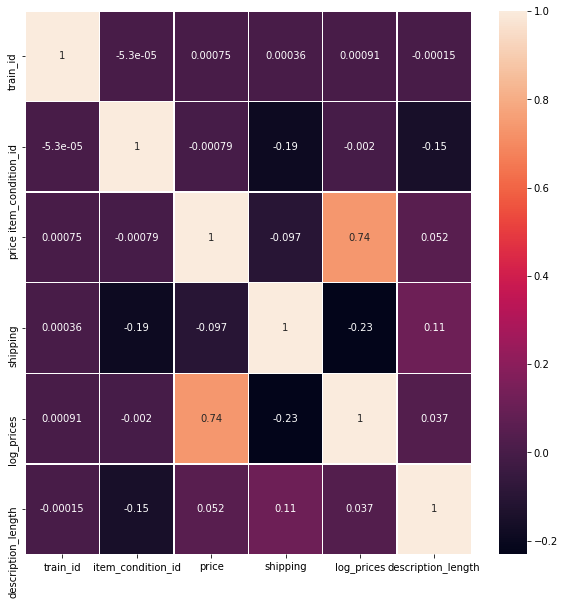

In [40]:
#Sử dụng correlation matrix để tính độ tương quan giữa các feature với feature price
columns = list(train_data.columns)
plt.figure(figsize = (10, 10))
sns.heatmap(train_data[columns].corr(), annot = True, linewidth = 0.5)
plt.show()

In [41]:
#Scale description_length về dạng (-1,1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(np.array(train_data['description_length']).reshape(-1,1))  
train_des_length=scaler.transform(np.array(train_data['description_length']).reshape(-1,1))
val_des_length=scaler.transform(np.array(validation_data['description_length']).reshape(-1,1))
test_des_length=scaler.transform(np.array(test_data['description_length']).reshape(-1,1))

In [42]:
#Đưa hai feature item_condition_id và shipping về dạng ma trận thưa
from scipy.sparse import csr_matrix

features_train = csr_matrix(pd.get_dummies(train_data[['item_condition_id', 'shipping']],sparse=True).values)
features_val = csr_matrix(pd.get_dummies(validation_data[['item_condition_id', 'shipping']],sparse=True).values)
features_test = csr_matrix(pd.get_dummies(test_data[['item_condition_id', 'shipping']],sparse=True).values)
print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

(1333494, 2)
(148167, 2)
(3460725, 2)


In [43]:
#Kết hợp tất cả các feature trong tập train,validation và test
from scipy.sparse import hstack
X_train=hstack((bow_cat1_train,bow_cat2_train,bow_cat3_train,bow_brand_train,bow_name_train,tfidf_description_train,features_train,train_des_length)).tocsr()
X_val=hstack((bow_cat1_val,bow_cat2_val,bow_cat3_val,bow_brand_val,bow_name_val,tfidf_description_val,features_val,val_des_length)).tocsr()
X_test=hstack((bow_cat1_test,bow_cat2_test,bow_cat3_test,bow_brand_test,bow_name_test,tfidf_description_test,features_test,test_des_length)).tocsr()
print("Shape of train data: ",X_train.shape) 
print("Shape of cv data: ",X_val.shape)   
print("Shape of test data: ",X_test.shape)   

Shape of train data:  (1333494, 27427)
Shape of cv data:  (148167, 27427)
Shape of test data:  (3460725, 27427)


#**Mô hình huấn luyện**

**Linear regression**

In [44]:
#Sử dụng Linear regression để huấn luyện với hàm loss là rmsle và độ đo R-Squared 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

linearregression=LinearRegression(normalize=True)
linearregression.fit(X_train,train_data['log_prices'])  
ytrain_predict=linearregression.predict(X_train)
yval_predict=linearregression.predict(X_val)
train_error=np.sqrt(mean_squared_error(train_data['log_prices'],ytrain_predict))
val_error=np.sqrt(mean_squared_error(validation_data['log_prices'],yval_predict))
#Ở đây RMSLE được tính bởi căn bậc hai hàm mean squared error 
#Nguồn https://www.kaggle.com/questions-and-answers/60012

In [45]:
from sklearn.metrics import r2_score

train_r2_score = r2_score(train_data['log_prices'], ytrain_predict)
val_r2_score = r2_score(validation_data['log_prices'], yval_predict)

In [46]:
#Bảng hiển thị kết quả sau khi train ở hai tập train và validation
from prettytable import PrettyTable

linear_table=PrettyTable()
linear_table.field_names=['Score','Train','Validation']
linear_table.add_row(['RMSLE',train_error,val_error])
linear_table.add_row(['R2 Score',train_r2_score,val_r2_score])
print(linear_table)

In [47]:
#Bảng hiện thị độ chính xác của model
%matplotlib inline

fig, ax = plt.subplots(1, 2,figsize=(16, 8))

sns.regplot(ax=ax[0],x=train_data['log_prices'][40:80],y=ytrain_predict[40:80],marker="+")


sns.regplot(ax=ax[1],x=validation_data['log_prices'][40:80],y=yval_predict[40:80],color="g",marker="+")



**Ridge regression**

In [48]:
#Sử dụng ridgeCV để tìm hệ số alpha tốt nhất cho model ,sau đó sử dụng hàm Ridge để huần luyện với alpha đó và các tham số solver khác nhau
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), cv=3)
ridge_cv.fit(X_train, train_data['log_prices'])

In [49]:
print(ridge_cv.alpha_)

In [50]:
yval_predict_ridgecv = ridge_cv.predict(X_val)
ytrain_predict_ridgecv = ridge_cv.predict(X_train)

In [51]:
from sklearn.metrics import mean_squared_error

val_ridge_RMSLE = np.sqrt(mean_squared_error(validation_data['log_prices'],yval_predict_ridgecv))
train_ridge_RMSLE = np.sqrt(mean_squared_error(train_data['log_prices'],ytrain_predict_ridgecv))

In [52]:
from prettytable import PrettyTable

ridge_cv_table=PrettyTable()
ridge_cv_table.field_names=['Score','Train','Validation']
ridge_cv_table.add_row(['RMSLE',train_ridge_RMSLE,val_ridge_RMSLE])
ridge_cv_table.add_row(['Best Score',ridge_cv.score(X_train,train_data['log_prices']),ridge_cv.score(X_val,validation_data['log_prices'])])
print(ridge_cv_table)

In [53]:
#Huần luyện với alpha = 10 và solver = sag
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10,solver='sag',fit_intercept=False)

ridge.fit(X_train, train_data['log_prices'])
ytrain_predict_ridge=ridge.predict(X_train)
yval_predict_ridge=ridge.predict(X_val)
train_error_ridge = np.sqrt(mean_squared_error(train_data['log_prices'], ytrain_predict_ridge))
val_error_ridge=np.sqrt(mean_squared_error(validation_data['log_prices'],yval_predict_ridge))

In [54]:
ridge_table=PrettyTable()
ridge_table.field_names=['Score','Train','Validation']
ridge_table.add_row(['RMSLE',train_error_ridge,val_error_ridge])
ridge_table.add_row(['Best Score',ridge.score(X_train,train_data['log_prices']),ridge.score(X_val,validation_data['log_prices'])])
print(ridge_table)

**Dự đoán trên tập submission**

In [ ]:
ytest_predict_ridge=ridge_cv.predict(X_test)

In [ ]:
submission_data = pd.read_csv('sample_submission_stg2.csv')
submission_data.head(5)

In [ ]:
submission_data.shape

In [ ]:
submission_data.loc[:, 'price'] = np.expm1(ytest_predict_ridge)

In [ ]:
submission_data.head(5)

In [ ]:
submission_data.to_csv('submission.csv', index=False)